<a href="https://colab.research.google.com/github/amulyagupta1278/Coding-Projects/blob/Deep-Learning/Lab9_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastai >./tmp
from fastai.basics import *
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.LSUN_BEDROOMS)
path.ls()

(#16) [Path('/root/.fastai/data/bedroom/c'),Path('/root/.fastai/data/bedroom/2'),Path('/root/.fastai/data/bedroom/6'),Path('/root/.fastai/data/bedroom/f'),Path('/root/.fastai/data/bedroom/a'),Path('/root/.fastai/data/bedroom/b'),Path('/root/.fastai/data/bedroom/0'),Path('/root/.fastai/data/bedroom/5'),Path('/root/.fastai/data/bedroom/8'),Path('/root/.fastai/data/bedroom/9')...]

In [ ]:
path

Path('/root/.fastai/data/bedroom')

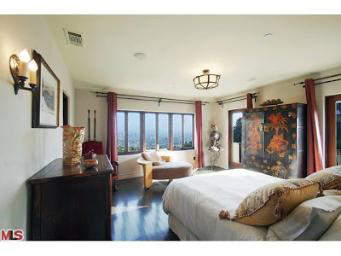

In [ ]:
Image.open(get_image_files(path)[0])

In [ ]:
class InvisibleTensor(TensorBase): #just a tensor representative. It has all the properties of a tensor, except it does not return anything unless we request it to,
    def show(self, ctx = None, **kwargs): return ctx

def generate_noise(fn, size = 100): return cast(torch.randn(size), InvisibleTensor)

In [ ]:
@typedispatch
def show_batch(x:InvisibleTensor, y:TensorImage, samples, ctxs=None, max_n = 10, nrows = None, ncols = None, figsize = None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples),max_n), nrows = nrows, ncols=ncols, figsize = figsize)
    ctxs = show_batch[object](x,y,samples, ctxs = ctxs, max_n = max_n, **kwargs)
    return ctxs

In [ ]:
@typedispatch
def show_results(x:InvisibleTensor, y:TensorImage, samples, outs, ctxs=None, max_n = 10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples),max_n),nrows=nrows, ncols= ncols, add_vert = 1, figsize =figsize)
    ctxs = [b.show(ctxs=c, **kwargs) for b,c,_ in zip(outs.itemgot(0), ctxs, range(max_n))]
    return ctxs

In [ ]:
bs=128
size = 64

we'll create a datablock, the task of which is to:

1. find where the data is stored (the path)
2. what type is our x and our y?
3. How should the model retrieve files from a path destination, 
4. how do you split the data, 
5. any transformations that need to be applied. 

In [ ]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = generate_noise,
                   get_items = get_image_files, 
                   splitter = IndexSplitter([]),
                   item_tfms = Resize(size,method = ResizeMethod.Crop),
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
) 

In [ ]:
dls = dblock.dataloaders(path,path=path, bs = bs)

In [ ]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([128, 100]), torch.Size([128, 3, 64, 64]))

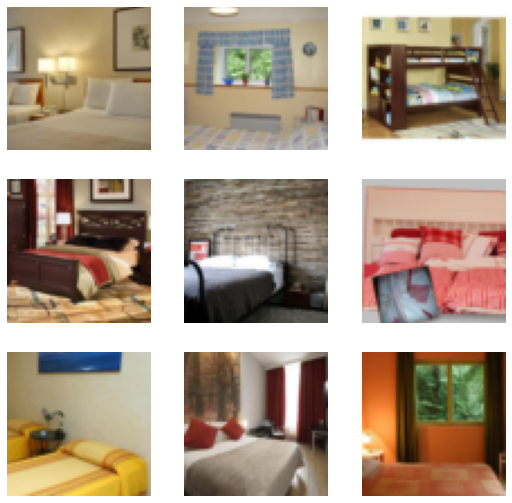

In [ ]:
dls.show_batch()

Implementing a GAN Module

In [ ]:
class GANModule(nn.Module):
    "Wrapper around a generator and critic model in order to create a GAN"

    def __init__(self, generator = None, critic = None, gen_mode = False):
        super().__init__()
        if generator is not None: self.generator = generator
        if critic is not None: self.critic = critic
        self.gen_mode = gen_mode
    
    def forward(self,*args):
        return self.generator(*args) if self.gen_mode else self.critic(*args)
    
    def switch(self,gen_mode = None):
        "Put the module in the generator mode as specified in the gen_mode, and in case its None, simply reverse the generation mode"
        assert gen_mode is None or type(gen_mode)==bool

        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode



In [ ]:
@delegates(ConvLayer.__init__)
def basic_critic(in_size, n_channels, n_features= 64, n_extra_layers = 0 , norm_type = NormType.Batch, **kwargs):
    "A basic critic for images `n_channels`x in_size x insize"
    layers = [ConvLayer(n_channels,n_features, 4, 2, 1, norm_type = None, **kwargs)]
    cur_size, cur_ftrs = in_size//2, n_features    
    layers+=[ConvLayer(cur_ftrs, cur_ftrs, 3, 1, norm_type = norm_type, **kwargs)]
    while cur_size>4:
        layers.append(ConvLayer(cur_ftrs,cur_ftrs*2, 4,2,1, norm_type = norm_type, **kwargs))
        cur_ftrs*=2
        cur_size//=2

    init = kwargs.get('init', nn.init.kaiming_normal_)
    layers+=[init_default(nn.Conv2d(cur_ftrs, 1, 4,padding=0), init), Flatten()]
    return nn.Sequential(*layers)

In [ ]:
class AddChannels(nn.Module):
    "Add n_dim channels at the end of the output, for the loss to work without throwing error, or calculating along the wrong direction during casting"
    def __init__(self,n_dims): 
        super().__init__()
        self.n_dims = n_dims
    def forward(self,x): return x.view(*list(x.shape), *[1]*self.n_dims)

basic generator

In [ ]:
@delegates(ConvLayer.__init__)
def basic_generator(outsize, n_channels ,in_size = 100, n_features=64, n_extra_layers = 0, **kwargs):
    "A basic generator from in_size to images of size n_channels x out_size x out_size. Notice the adaptive behavior. It does not depend on the input size. The architecture dynamically changes with whatever input size you set in this function"
    cur_size, cur_ftrs = 4, n_features//2
    
    while cur_size <outsize: cur_size*=2; cur_ftrs*=2 #the end result is that cur_size is going to be larget than the output size, and its a multiple of 4, so makes life easier for the generator
    
    layers = [AddChannels(2), ConvLayer(in_size, cur_ftrs, 4,1, transpose = True, **kwargs)] #need to add channels we will be adding a 2D shape noise tensor as input, but the conv2dTranspose operation expects a 4d input
    #transpose=True simply replaces Conv2d operation with a conv2dtranspose operation (deconvolution operation, or a decoder operation), which is needed because here the input is a decoded vector of some random features. 
    cur_size = 4
    while cur_size<outsize//2: # add layer until you get to out_size
        layers.append(ConvLayer(cur_ftrs, cur_ftrs//2, 4 , 2,1, transpose=True, **kwargs))
        cur_ftrs//=2
        cur_size*=2
    
    layers +=[ConvLayer(cur_ftrs, cur_ftrs, 3, 1, 1, transpose =True, **kwargs) for _ in range(n_extra_layers)]
    layers +=[nn.ConvTranspose2d(cur_ftrs, n_channels, 4,2,1, bias=False), nn.Tanh()] #turns out nn.Tanh works better with vanilla GANs than sogmoid
    return nn.Sequential(*layers)


In [ ]:
critic = basic_critic(64,3)
generator = basic_generator(64,3)
mdl = GANModule(critic = critic, generator = generator)
real = torch.rand(2,3,64,64)
real_pred = mdl(real) #right now its in critic mode, so expect a tensor of 2,1 in shape, which consists of classification predictions 
real_pred.shape


torch.Size([2, 1])

In [ ]:
mdl.switch(gen_mode = True)
noise = torch.randn(2,100)
noise.shape
fake = mdl(noise)
fake.shape

torch.Size([2, 3, 64, 64])

THE GAN LOSS

In [ ]:
class GANLoss(GANModule):
    "wrapper around crit loss and the gen loss"
    def __init__(self, gen_loss_func, crit_loss_func, gan_model):
        super().__init__()
        store_attr('gen_loss_func, crit_loss_func, gan_model')

    def generator(self, output, target):
        "Evaluate the output with the critic"
        fake_pred = self.gan_model.critic(output)
        self.gen_loss = self.gen_loss_func(fake_pred, output, target)
        return self.gen_loss

    def critic(self,real_pred,input):
        "Create some 'fake_pred' with the generator from 'input' and then compare them to the real_pred in the self.crit_loss_func"
        fake = self.gan_model.generator(input).requires_grad_(False)
        fake_pred  = self.gan_model.critic(fake)
        self.crit_loss = self.crit_loss_func(real_pred, fake_pred)
        return self.crit_loss

In [ ]:
def set_freeze_model(m, rg = False):
    for p in m.parameters(): p.requires_grad_(rg)


In [ ]:
class GANTrainer(Callback):
    "Handles GAN Training"
    run_after = TrainEvalCallback
    def __init__(self, switch_eval = False, clip = None, beta = 0.98, gen_first = False, show_img = True):
        store_attr('switch_eval, clip, gen_first, show_img')
        self.gen_loss, self.crit_loss = AvgSmoothLoss(beta = beta), AvgSmoothLoss(beta = beta)

    def _set_trainable(self):
        train_model = self.generator if self.gen_mode else self.critic
        loss_model = self.generator if not self.gen_mode else self.critic
        set_freeze_model(train_model, True)
        set_freeze_model(loss_model,  False)

        if self.switch_eval:
            train_model.train()
            loss_model.eval()
        
    def before_fit(self):
        "Initialize smootherners"
        self.generator, self.critic = self.model.generator, self.model.critic
        self.gen_mode = self.gen_first
        self.switch(self.gen_mode)
        self.crit_losses, self.gen_losses = [],[]
        self.gen_loss.reset()
        self.crit_loss.reset()

    def before_validate(self):
        #during validation, you want to check the performance of the generator (in general, GAN critic loss is not a good indicator of the performance for generative tasks)
        self.switch(gen_mode = True)

    def before_batch(self):
        "Clamp the weights with self.clip is its not None, and set the corrent input output mappings"
        if self.training and self.clip is not None:
            for p in self.critic.parameters(): p.data.clamp_(-self.clip, self.clip)
        if not self.gen_mode:
            (self.learn.xb, self.learn.yb) = (self.yb, self.xb)
    
    def after_batch(self):
        "Record my last loss in the proper list of averaged smoothened losses"
        if not self.training: return 
        if self.gen_mode:
            self.gen_loss.accumulate(self.learn)
            self.gen_losses.append(self.gen_loss.value)
            self.last_gen = self.learn.to_detach(self.pred)
        else:
            self.crit_loss.accumulate(self.learn)
            self.crit_losses.append(self.crit_loss.value)
        
    
    def before_epoch(self):
        "Put the critic or the generator back to eval if necessary"
        self.switch(self.gen_mode)

    def switch(self, gen_mode = None):
        "Switch not only the model, but the loss function as well. If gen_mode is provided, switch to that!"
        self.gen_mode = (not self.gen_mode) if gen_mode is None else gen_mode
        self._set_trainable()
        self.model.switch(self.gen_mode)
        self.loss_func.switch(self.gen_mode)


In [ ]:
class FixedGANSwitcher(Callback):
    "Switcher to do n_crit iterations of the critic then n_gen iterations of the generator"
    run_after = GANTrainer 
    def __init__(self, n_crit = 1, n_gen = 1): store_attr('n_crit,n_gen')
    def before_train(self): self.n_c, self.n_g = 0,0

    def after_batch(self):
        "Switch the model if necessary"
        if not self.training: return 
        if self.learn.gan_trainer.gen_mode:
            self.n_g+=1
            n_iter,n_in,n_out = self.n_gen, self.n_c, self.n_g

        else:
            self.n_c+=1
            n_iter, n_in, n_out = self.n_crit,self.n_g, self.n_c
        
        target = n_iter if isinstance(n_iter,int) else n_iter(n_in)
        if target ==n_out:
            self.learn.gan_trainer.switch()
            self.n_c, self.n_g = 0,0
        

GAN loss functions

In [ ]:
def gan_loss_from_func(loss_gen, loss_crit, weights_gen = None):
    "Define Loss functions from a GAN from loss_gen and loss_crit"

    def _loss_G(fake_pred, output, target, weights_gen = weights_gen):
        ones = fake_pred.new_ones(fake_pred.shape[0])
        weights_gen = ifnone(weights_gen, (1.,1.))
        return weights_gen[0]*loss_crit(fake_pred,ones) + weights_gen[1]*loss_gen(output,target) # critic should be able to predict each fake_pred as a label of 0
    #here we are checking how good the generator is at fooling the critic, by checking the accuracy of fake_pred being predicted as a 1. 

    def _loss_C(real_pred,fake_pred):
        ones = real_pred.new_ones(real_pred.shape[0])
        zeros = fake_pred.new_zeros(fake_pred.shape[0])
        return (loss_crit(real_pred,ones) + loss_crit(fake_pred,zeros))/2 #crit loss should predict real images as label 1, and fake images as label 0
    
    return _loss_G, _loss_C

In [ ]:
#just functions that take the mean and differences of predictions
def _tk_mean(fake_pred,output, target): return fake_pred.mean()

def _tk_diff(real_pred,fake_pred): return real_pred.mean()-fake_pred.mean()


In [ ]:
from types import ClassMethodDescriptorType
@delegates()
class GANLearner(Learner):
    "A suitable learner for GANs"
    def __init__(self,dls,generator,critic, gen_loss_func,crit_loss_func, switcher=None, gen_first = False,
                 switch_eval = True, show_img=True, clip=None, cbs=None, metrics=None, **kwargs):
        gan = GANModule(generator,critic)
        loss_func = GANLoss(gen_loss_func,crit_loss_func, gan)
        if switcher is None: switcher = FixedGANSwitcher(n_crit = 5, n_gen = 1)
        trainer = GANTrainer(clip=clip, switch_eval = switch_eval, gen_first = gen_first, show_img = show_img)
        cbs = L(cbs) + L(trainer,switcher)
        metrics = L(metrics) + L(*LossMetrics('gen_loss, crit_loss'))
        super().__init__(dls,gan,loss_func = loss_func, cbs = cbs, metrics = metrics, **kwargs)

    
    @classmethod
    def from_learners(cls, gen_learn, crit_learn, switcher =None, weights_gen =None, **kwargs):
        "Create a GAN from already trained/imported gen/crit learner objects"
        losses = gan_loss_from_func(gen_learn.loss_func, crit_learn.loss_func, weights_gen = weights_gen)
        return cls(gen_learn.dls, gen_learn.model, crit_learn.model, *losses, switcher = switcher, **kwargs)
    
    @classmethod
    def wgan(cls, dls, generator, critic, switcher =None, clip = 0.01, switch_eval = False, **kwargs):
        "Create a WGAN from data, generator, and critic"
        return cls(dls, generator, critic, _tk_mean, _tk_diff, switcher = switcher, clip = clip, switch_eval = switch_eval, **kwargs)

#add the remaning initialization variables as in the standard GAN Learner, (like metrics, etc)
GANLearner.from_learners = delegates(to = GANLearner.__init__)(GANLearner.from_learners)
GANLearner.wgan = delegates(to = GANLearner.__init__)(GANLearner.wgan)

In [ ]:
from fastai.callback.all import *
generator = basic_generator(64, n_channels = 3, n_extra_layers = 1)
critic = basic_critic(64, n_channels = 3, n_extra_layers = 1, act_cls = partial(nn.LeakyReLU, negative_slope = 0.2))

In [ ]:
learn = GANLearner.wgan(dls, generator, critic, opt_func = RMSProp, show_img = True)

In [ ]:
learn.recorder.train_metric = True
learn.recorder.valid_metrics = False

In [ ]:
learn.fit(40, 2e-4, wd=0.)

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
